In [47]:
# 분석에 필요한 패키지 불러오기
import os
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve
import statsmodels.api as sm
import matplotlib.pyplot as plt
import itertools
import time

In [48]:
# 현재경로 확인
os.getcwd()

'C:\\Users\\Jang\\python_machine_deep_learning\\5. regression'

In [49]:
ploan = pd.read_csv("./data/Personal Loan.csv")
ploan.head()

,ID,Age,Experience,Income,ZIP Code,Family,CCAvg,Education,Mortgage,Personal Loan,Securities Account,CD Account,Online,CreditCard
0,1,25,1,49,91107,4,1.6,1,0,0,1,0,0,0
1,2,45,19,34,90089,3,1.5,1,0,0,1,0,0,0
2,3,39,15,11,94720,1,1.0,1,0,0,0,0,0,0
3,4,35,9,100,94112,1,2.7,2,0,0,0,0,0,0
4,5,35,8,45,91330,4,1.0,2,0,0,0,0,0,1


In [50]:
# 의미없는 변수 제거
ploan_processed = ploan.dropna().drop(['ID','ZIP Code'], axis=1, inplace=False)

In [51]:
# 여기서는 상수항 추가 안함

# Lasso & RIdge

In [52]:
from sklearn.linear_model import Ridge, Lasso, ElasticNet

In [72]:
feature_columns = list(ploan_processed.columns.difference(["Personal Loan"]))
X = ploan_processed[feature_columns]
y = ploan_processed['Personal Loan'] # 대출여부: 1 or 0

train_x, test_x, train_y, test_y = train_test_split(X, y, stratify=y,train_size=0.7,test_size=0.3,random_state=42)
print(train_x.shape, test_x.shape, train_y.shape, test_y.shape)

(1750, 11) (750, 11) (1750,) (750,)


In [63]:
## lasso 적합
ll = Lasso(alpha=0.01) ## alpha는 lasso 식에서 람다를 의미함.
## alpha값을 너무 높이면 더 많은 변수가 0이 되고, 예측력이 떨어질 수 있으니 적당한 값을 넣어야 한다
ll.fit(train_x, train_y)

Lasso(alpha=0.01, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

In [64]:
## 회귀 계수 출력
ll.coef_

# 첫번째, 네번째, 뒤에서 2개의 변수의 계수가 0이 되었다. 
# 이 4개의 변수가 서로 correlation이 높다. 즉, 이들 사이에서 다중공선성이 높다.
# 이 4개의 변수를 삭제하고 모델을 만들면 다중공선성이 조금 완화될 가능성이 있다

# 하지만, 이 변수들이 중요한 변수일 수도 있다
# 변수의 p-value가 높은 등 중요한 변수의 계수가 lasso적합에 의해 0이 될수도 있으니 주의해야한다

array([ 0.00000000e+00,  2.04783983e-03,  1.14390390e-01, -0.00000000e+00,
        6.58342418e-02,  4.76625359e-04,  3.13396711e-02,  3.55393865e-03,
        1.31719530e-05,  0.00000000e+00, -0.00000000e+00])

In [65]:
# 0.5 이상이면 1로, 아니면 0으로 판단함.
def cut_off(y,threshold):
    Y = y.copy() # copy함수를 사용하여 이전의 y값이 변화지 않게 함
    Y[Y>threshold]=1
    Y[Y<=threshold]=0
    return(Y.astype(int))

# accuracy 구하는 함수
def acc(cfmat):
    return (cfmat[0,0] + cfmat[1,1]) / (cfmat[0,0] + cfmat[0,1] + cfmat[1,0] + cfmat[1,1])

In [75]:
## 예측, confusionmatrix, acc계산
pred_y_lasso = ll.predict(test_x)
pred_Y_lasso = cut_off(pred_y_lasso, 0.5)
cfmat = confusion_matrix(test_y, pred_Y_lasso)
acc(cfmat)

# accuracy = 0.936 .... lasso 해서 변수 몇개 제거 -> 정확도는 조금 떨어짐

0.936

AUC: 0.9479361648752436


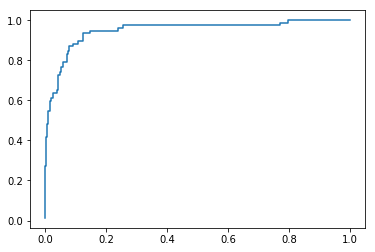

In [217]:
fpr, tpr, thresholds = metrics.roc_curve(test_y, pred_y_lasso, pos_label=1)
# Print ROC curve
plt.plot(fpr,tpr)
# Print AUC
auc = np.trapz(tpr,fpr)
print('AUC:', auc)

In [78]:
## ridge 적합
rr = Ridge(alpha=0.01)
rr.fit(train_x, train_y)

Ridge(alpha=0.01, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

In [79]:
## ridge result
rr.coef_

array([-3.71283678e-03,  7.37570775e-03,  3.54973975e-01, -5.28579506e-02,
        7.83404224e-02,  4.12823466e-03,  3.62504712e-02,  3.27385112e-03,
        1.73105480e-06, -1.91297381e-02, -8.77388670e-02])

In [80]:
## lasso result
ll.coef_

array([ 0.00000000e+00,  2.04783983e-03,  1.14390390e-01, -0.00000000e+00,
        6.58342418e-02,  4.76625359e-04,  3.13396711e-02,  3.55393865e-03,
        1.31719530e-05,  0.00000000e+00, -0.00000000e+00])

In [83]:
## ridge y예측, confusion matrix, acc계산 
pred_y_ridge = rr.predict(test_x)
pred_Y_ridge = cut_off(pred_y_ridge, 0.5)
cfmat2 = confusion_matrix(test_y, pred_Y_ridge)
acc(cfmat2)

## accuracy = 0.932 ... lasso보다 조금 떨어짐

0.932

AUC: 0.9494992377607533


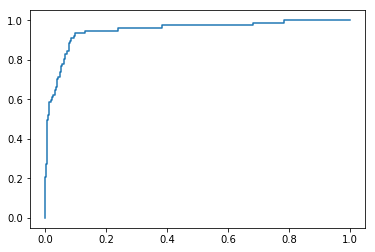

In [85]:
fpr, tpr, thresholds = metrics.roc_curve(test_y, pred_y_ridge, pos_label=1)
# Print ROC curve
plt.plot(fpr,tpr)
# Print AUC
auc = np.trapz(tpr,fpr)
print('AUC:', auc)

In [101]:
## labmda값 0.001 ~ 10까지 범위 설정

alpha = np.logspace(-3,1,5) ## 10의-3승 부터 10의1승 까지를 5개로 나눠서 저장 
alpha # -0.001, -0.01, -0.1, 1, 10

array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01])

In [98]:
## lasso 적합시, lambda에 따른 회귀계수 및 accuracy 변화

data = []
acc_table=[]
for i, a in enumerate(alpha):
    lasso = Lasso(alpha=a).fit(train_x, train_y)
    data.append(pd.Series(np.hstack([lasso.intercept_, lasso.coef_])))
    pred_y = lasso.predict(test_x) # full model
    pred_y= cut_off(pred_y,0.5)
    cfmat = confusion_matrix(test_y, pred_y)
    acc_table.append((acc(cfmat)))
    

df_lasso = pd.DataFrame(data, index=alpha).T
acc_table_lasso = pd.DataFrame(acc_table, index=alpha).T

In [99]:
df_lasso 

# 람다(여기서는 alpha)가 증가할 수록 0이 되는 회귀계수가 많아진다

,0.001,0.01,0.1,1.0,10.0
0,-0.335006,-0.381869,-0.143698,-0.113103,0.102286
1,-0.002109,0.000000,0.000000,0.000000,-0.000000
2,0.006829,0.002048,0.000000,0.000000,0.000000
3,0.322174,0.114390,0.000000,0.000000,0.000000
4,-0.043385,-0.000000,-0.000000,-0.000000,-0.000000
5,0.076771,0.065834,0.000000,0.000000,0.000000
6,0.002534,0.000477,0.000000,0.000000,-0.000000
7,0.035728,0.031340,0.000000,0.000000,0.000000
8,0.003313,0.003554,0.003291,0.002893,0.000000
9,0.000004,0.000013,0.000016,0.000000,0.000000


In [100]:
acc_table_lasso

# 람다=0.01 일 때 성능이 가장 좋다

,0.001,0.01,0.1,1.0,10.0
0,0.932,0.936,0.894667,0.897333,0.897333


In [102]:
## ridge 적합시, lambda에 따른 회귀계수 및 accuracy 변화

data = []
acc_table=[]
for i, a in enumerate(alpha):
    ridge = Ridge(alpha=a).fit(train_x, train_y)
    data.append(pd.Series(np.hstack([ridge.intercept_, ridge.coef_])))
    pred_y = ridge.predict(test_x) # full model
    pred_y= cut_off(pred_y,0.5)
    cfmat = confusion_matrix(test_y, pred_y)
    acc_table.append((acc(cfmat)))

    
df_ridge = pd.DataFrame(data, index=alpha).T
acc_table_ridge = pd.DataFrame(acc_table, index=alpha).T

In [103]:
df_ridge

,0.001,0.01,0.1,1.0,10.0
0,-0.289557,-0.289565,-0.289645,-0.290438,-0.297581
1,-0.003713,-0.003713,-0.003713,-0.003716,-0.003723
2,0.007376,0.007376,0.007376,0.007378,0.007388
3,0.355019,0.354974,0.354529,0.350141,0.311781
4,-0.052866,-0.052858,-0.052782,-0.052037,-0.045541
5,0.078340,0.078340,0.078341,0.078347,0.078316
6,0.004128,0.004128,0.004129,0.004136,0.004175
7,0.036250,0.036250,0.036254,0.036289,0.036578
8,0.003274,0.003274,0.003274,0.003278,0.003313
9,0.000002,0.000002,0.000002,0.000002,0.000004


In [105]:
acc_table_ridge

## 거의 변화 없음 --> 더이상 축소할만한 변수가 딱히 없다

,0.001,0.01,0.1,1.0,10.0
0,0.932,0.932,0.932,0.932,0.932


## labmda값의 변화에 따른 회귀계수 축소 시각화

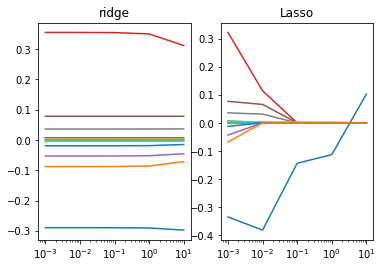

In [108]:
import matplotlib.pyplot as plt
ax1 = plt.subplot(121)
plt.semilogx(df_ridge.T)
plt.xticks(alpha)
plt.title("ridge")

ax2 = plt.subplot(122)
plt.semilogx(df_lasso.T)
plt.xticks(alpha)
plt.title("Lasso")

plt.show()

## 결론!!
# 1. lasso의 경우에는, lambda값에 따라 결과의 변화가 너무 심해서 안좋음
# 2. lasso, ridge 둘다, p-value가 높은 변수가 0으로 가는 등의 문제점
# 3. 반대로, 좋지 않은 변수가 0으로 가지 않는 문제점

# --> ridge나 lasso는 맞지 않는 데이터 --> 다른 방식(변수선택법, 다른 regression)을 사용하는 것이 더 적절함